# Deploy Grafana on Kubernetes Cluster

Set up a Grafana tool to collect and analyze analytics from some applications. 
Testing this project on KinD Cluster at local machine. KinD is quick and easy way to create Kubernetes cluster for testing and developing in your own desktop. 

Jupyter notebook with bash kernal used as documentation tool.
Below you can find more details.

1.) Create kinD cluster

2.) Create a namespace for Grafana grafana-monitoring-datacenter.

3.) Create grafana-deployment-datacenter deployment the namespace you created.

a. Replica counts should be 1.

b. Container name should be grafana-container-datacenter and use grafana/grafana:latest image.

c. Container port should be 3000. Set resources limits memory to 2Gi and CPU to 1000m, requests for memory 1Gi and for CPU 500m.

d. Volume mount name should be grafana-storage. Its mountPath should be /var/lib/grafana. Volume name should be grafana-storage, should be emptyDir {}.

4.) Create grafana-service-datacenter service under the same namespace. It must be of NodePort type, its port must be 3000, target port must be 3000 and nodePort must be 32000.

You can use any labels as per your choice.

## Create a Kind Cluster with 1 control plane and 1 worker node

In [2]:
cat 1c1w.yaml

---
kind: Cluster
apiVersion: kind.x-k8s.io/v1alpha4
nodes:
- role: control-plane
  extraPortMappings:
  - containerPort: 32000
    hostPort: 32000
    listenAddress: 0.0.0.0
    protocol: TCP
- role: worker

In [3]:
kind create cluster --config 1c1w.yaml

Creating cluster "kind" ...
 ✓ Ensuring node image (kindest/node:v1.19.1) 🖼
 ✓ Preparing nodes 📦 📦 7l
 ✓ Writing configuration 📜7l
 ✓ Starting control-plane 🕹️7l
 ✓ Installing CNI 🔌7l
 ✓ Installing StorageClass 💾7l
 ✓ Joining worker nodes 🚜7l
Set kubectl context to "kind-kind"
You can now use your cluster with:

kubectl cluster-info --context kind-kind

Thanks for using kind! 😊


In [4]:
kubectl get pods -n kube-system

NAME                                         READY   STATUS    RESTARTS   AGE
coredns-f9fd979d6-jb99g                      1/1     Running   0          2m6s
coredns-f9fd979d6-zgp2n                      1/1     Running   0          2m6s
etcd-kind-control-plane                      1/1     Running   0          2m11s
kindnet-zcmzn                                1/1     Running   0          112s
kindnet-zkhs2                                1/1     Running   0          2m6s
kube-apiserver-kind-control-plane            1/1     Running   0          2m11s
kube-controller-manager-kind-control-plane   1/1     Running   0          2m11s
kube-proxy-8zhsp                             1/1     Running   0          2m6s
kube-proxy-zhrhl                             1/1     Running   0          112s
kube-scheduler-kind-control-plane            1/1     Running   0          2m11s


In [5]:
kubectl cluster-info --context kind-kind

Kubernetes master is running at https://127.0.0.1:38557
KubeDNS is running at https://127.0.0.1:38557/api/v1/namespaces/kube-system/services/kube-dns:dns/proxy

To further debug and diagnose cluster problems, use 'kubectl cluster-info dump'.


In [6]:
cat grafana-app.yaml

---
apiVersion: apps/v1
kind: Deployment
metadata:
  name: grafana-deployment-datacenter
  namespace: grafana-monitoring-datacenter
  labels:
    app: grafana
spec:
  replicas: 1
  selector:
    matchLabels:
      app: grafana
  template:
    metadata:
      labels:
        app: grafana
    spec:
      containers:
      - name: grafana-container-datacenter
        image: grafana/grafana:latest
        ports:
        - containerPort: 3000
        resources:
          limits:
            memory: "2Gi"
            cpu: "1000m"
          requests:
            memory: "1Gi"
            cpu: "500m"
        volumeMounts:
        - name: grafana-storage
          mountPath: /var/lib/grafana
      volumes:
      - name: grafana-storage
        emptyDir: {}
---
apiVersion: v1
kind: Service
metadata:
  name: grafana-service-datacenter
  namespace: grafana-monitoring-datacenter
spec:
  type: NodePort
  ports:
  - port: 3000
    targetPort: 3000
    nodePort: 32000
  selector:
    app: grafana



In [7]:
kubectl create ns grafana-monitoring-datacenter

namespace/grafana-monitoring-datacenter created


In [8]:
kubectl apply -f grafana-app.yaml

deployment.apps/grafana-deployment-datacenter created
service/grafana-service-datacenter created


In [9]:
kubectl get deploy -n grafana-monitoring-datacenter

NAME                            READY   UP-TO-DATE   AVAILABLE   AGE
grafana-deployment-datacenter   1/1     1            1           100s


In [10]:
kubectl get svc -n grafana-monitoring-datacenter

NAME                         TYPE       CLUSTER-IP      EXTERNAL-IP   PORT(S)          AGE
grafana-service-datacenter   NodePort   10.96.194.163   <none>        3000:32000/TCP   114s


localhost:32000 will take to web interface of grafana app. Checking with the grafana-cli

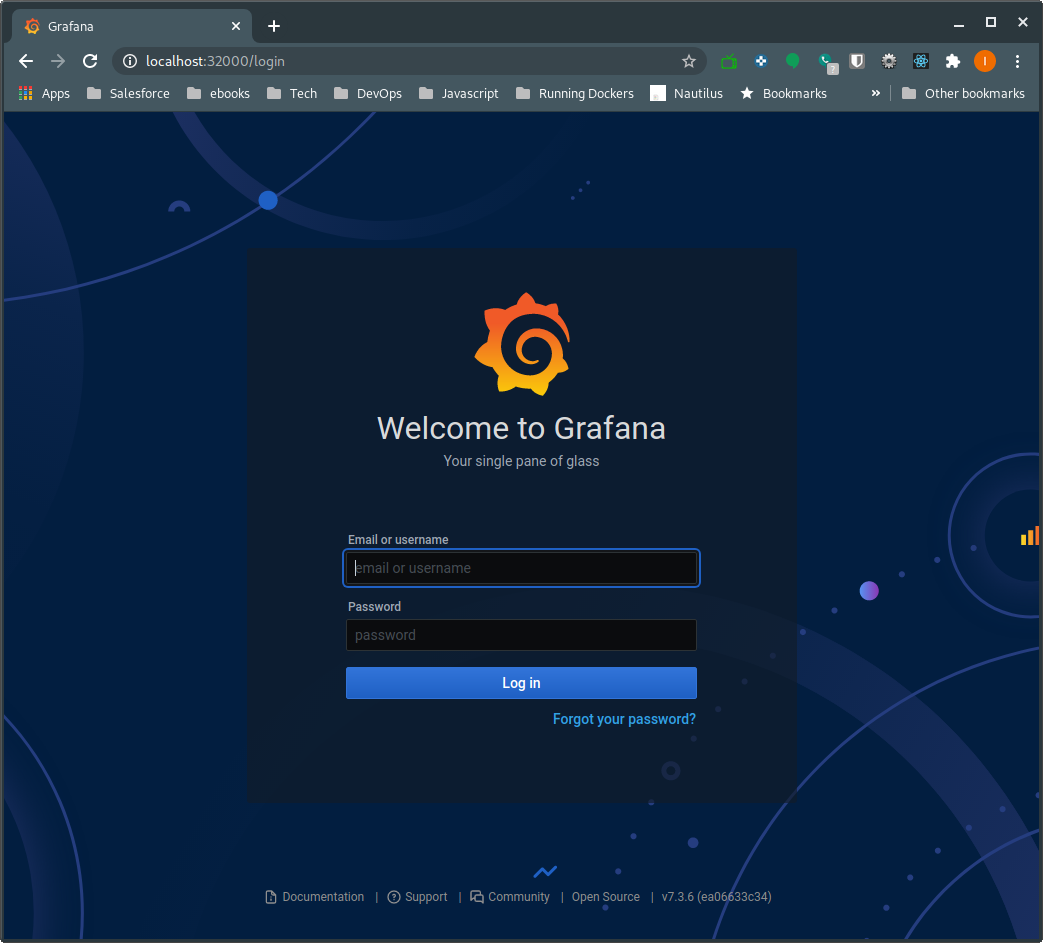

In [12]:
kubectl get pods -n grafana-monitoring-datacenter

NAME                                             READY   STATUS    RESTARTS   AGE
grafana-deployment-datacenter-5bd88fc68f-99ns6   1/1     Running   0          5m58s


In [13]:
kubectl exec -it grafana-deployment-datacenter-5bd88fc68f-99ns6 -n grafana-monitoring-datacenter -- grafana-cli --version

Grafana CLI version 7.3.6


In [14]:
kubectl exec -it grafana-deployment-datacenter-5bd88fc68f-99ns6 -n grafana-monitoring-datacenter -- grafana-cli --help

NAME:
   Grafana CLI - A new cli application

USAGE:
   grafana-cli [global options] command [command options] [arguments...]

VERSION:
   7.3.6

AUTHOR:
   Grafana Project <hello@grafana.com>

COMMANDS:
   plugins  Manage plugins for grafana
   admin    Grafana admin commands
   help, h  Shows a list of commands or help for one command

GLOBAL OPTIONS:
   --pluginsDir value       Path to the Grafana plugin directory (default: "/var/lib/grafana/plugins") [$GF_PLUGIN_DIR]
   --repo value             URL to the plugin repository (default: "https://grafana.com/api/plugins") [$GF_PLUGIN_REPO]
   --pluginUrl value        Full url to the plugin zip file instead of downloading the plugin from grafana.com/api [$GF_PLUGIN_URL]
   --insecure               Skip TLS verification (insecure) (default: false)
   --debug                  Enable debug logging (default: false)
   --configOverrides value  Configuration options to override defaults as a string. e.g. cfg:default.paths.log=/dev/null
   --ho

## Delete cluster 

In [ ]:
# kind delete cluster